### **Lunar Lander DDQN KERAS using an Agent Class**

Prepared for hard and soft update. This execution is with soft update

- Hard update : copy weights
- Soft update : soft update Polyak

This is a naive version vectorized of the DDQN Algorithm for the Lunar Lander env <br>
Vectorizing we obtain a version that is faster and it is 'functional' as it works <br>
It should converge around 200 episodes in soft or hard update

The Double DQN (DDQN) uses two networks one as a target and one as the trained network <br>

The target network is a copy of the online network that is updated less frequently, <br>
and is used to generate the target values for the Q-learning update

It includes a soft update of the weights, instead of substituting the weights between the networks it blends them together using a Polyak averaging This was an improvement on the pure DDQN algorithm

It has room for improvement by modifying some of the hyperparameters. Try to obtain a shorter and more stable training convergence.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import gymnasium as gym
import numpy as np
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import deque
import random

import time
from PIL import Image

import sys
sys.stderr = open('err.txt', 'w')

E0000 00:00:1739201306.458663  453839 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739201306.472296  453839 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Activate GPU
from tensorflow.python.client import device_lib
from tensorflow.config import list_physical_devices
print('Num GPUs Available: ',len(list_physical_devices('GPU')))
devices = device_lib.list_local_devices()
gpu_devices = [device for device in devices if device.device_type == 'GPU']
for gpu in gpu_devices:
    print('Using', gpu.physical_device_desc)

Num GPUs Available:  0


#### **Environment setup**

In [3]:
# GPU
from tensorflow.python.client import device_lib
devices = device_lib.list_local_devices()
gpu_devices = [device for device in devices if device.device_type == 'GPU']
for gpu in gpu_devices:
    print('Using', gpu.physical_device_desc)

In [4]:
env = gym.make('LunarLander-v3')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n


#### **Hyperparameters**

In [5]:
max_steps = 1200
max_episodes = 1200
ROLLING_WINDOW = 40

batch_size = 64
gamma = 0.99                
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.99 
learning_rate = 0.0005
MEMORY_SIZE = 100000

solved_threshold = 200

tau = 0.05  
retrain_steps_soft = 15            # We copy weights every retrain_steps 
                                   # Soft update, it is high for long retrain periods. Small for short retrain
retrain_steps_hard = 1000
UPDATE_SOFT = True                # if False then HARD UPDATE

#lr: 0.0001 gamma 0.99 batch_size 128 tau  0.15 epsilon decay 0.99 retrain_steps  5

#### **DDQN Agent Class**

In [6]:
class Agent_DDQN():
    def __init__(self, states, actions, alpha, gamma, epsilon, tau, soft_flag):
        self.nS = states
        self.nA = actions
        self.replay_buffer = deque([], maxlen=MEMORY_SIZE)
        self.alpha = alpha
        self_tau = tau
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.model        = self.build_NN("model")
        self.target_model = self.build_NN("target_model")
        self.target_model.set_weights(self.model.get_weights())
        self.loss = []
        self.counter_retrain_hard = 0
        self.counter_retrain_soft = 0
        self.soft_flag = soft_flag
        print('DDWN strategy SOFT reset weights' if self.soft_flag else "DDQN strategy HARD reset weights")

    def build_NN(self, name):
        inputs = Input(shape=(state_size,), name="state_input")
        x = Dense(24, activation='relu', name="dense_1")(inputs)
        x = Dense(24, activation='relu', name="dense_2")(x)
        outputs = Dense(action_size, activation='linear', name="output_layer")(x)
        model = Model(inputs=inputs, outputs=outputs, name=name)
        model.compile(loss='mse', optimizer=Adam(learning_rate=learning_rate))
        model.summary()
        return model

    def action(self, state):
        action_vals = self.model.predict(state, verbose=0) 
        return np.argmax(action_vals[0])
    
    def random_action(self):
        return random.randrange(self.nA) #Explore
    
    def sample_experiences(self, batch_size):
        indices = np.random.choice(len(self.replay_buffer), batch_size, replace=False)
        batch = [self.replay_buffer[i] for i in indices]
        states, actions, rewards, next_states, dones = zip(*batch)
        return (
            np.vstack(states),
            np.array(actions),
            np.array(rewards),
            np.vstack(next_states),
            np.array(dones, dtype=np.float32)
            )
    def store_experience(self, state, action, reward, next_state, done):             # memorize
        self.replay_buffer.append((state, action, reward, next_state, done))
    
    def experience_replay_DDQN(self, batch_size):
        if len(self.replay_buffer) < batch_size:
            return
        minibatch = random.sample(self.replay_buffer, batch_size)
        states, actions, rewards, next_states, dones = self.sample_experiences(batch_size)
        next_q_values = self.model.predict(next_states, verbose=0)
        best_actions = np.argmax(next_q_values, axis=1)
        target_q_values = self.target_model.predict(next_states, verbose=0)
        
        targets = rewards + gamma * target_q_values[np.arange(batch_size), best_actions] * (1 - dones)
        
        q_values = self.model.predict(states, verbose=0)
        q_values[np.arange(batch_size), actions] = targets
        self.model.fit(states, q_values, epochs=1, verbose=0)

    # Apply weights updates
        if self.soft_flag:
            self.counter_retrain_soft += 1
            if self.counter_retrain_soft % retrain_steps_soft == 0:   
                self.soft_update(self.model, self.target_model)
                self.counter_retrain_soft = 0
        else:
            self.counter_retrain_hard += 1
            if self.counter_retrain_hard % retrain_steps_hard == 0:   
                self.hard_update(model,target_model)
                self.counter_retrain_hard = 0
        
        return


    def soft_update(self, model, target_model):
        target_weights = target_model.get_weights()
        model_weights = model.get_weights()
        new_weights = [
            tau * mw + (1 - tau) * tw for mw, tw in zip(model_weights, target_weights)
        ]
        target_model.set_weights(new_weights)
        return
    
    def hard_update(self, model, target_model):
        target_weights = self.model.get_weights()
        target_model.set_weights(target_weights)
        return

#### **Support Functions**

In [7]:
def select_action_greedy(state, agent_DDQN): 
    """ Greedy action selection """
    if np.random.rand() <= epsilon:
        return agent_DDQN.random_action()
    return agent_DDQN.action(state) 

#### **Initialize Agent**

In [8]:
envCartPole = gym.make('LunarLander-v3')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

agent = Agent_DDQN(state_size, action_size, learning_rate, gamma, epsilon, tau, UPDATE_SOFT)

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ state_input (InputLayer)        │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 24)             │           216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 24)             │           600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 4)              │           100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 916 (3.58 KB)

 Trainable params: 916 (3.58 KB)

 Non-trainable params: 0 (0.00 B)

Model: "target_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ state_input (InputLayer)        │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 24)             │           216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 24)             │           600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 4)              │           100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 916 (3.58 KB)

 Trainable params: 916 (3.58 KB)

 Non-trainable params: 0 (0.00 B)

DDWN strategy SOFT reset weights


#### **Training Phase**

In [9]:
# Training loop
episode_rewards = []
rolling_avg_rewards = []

start_time = time.time()

for episode in range(max_episodes):
    state, _ = env.reset()
    state = np.reshape(state, [1, state_size])
    total_reward = 0
    done = False
    terminated = False
    truncated = False
    step = 0
    for e in range(max_steps):                       # Should be While True, however we limit number of eps
        step = step + 1
        # Epsilon-greedy policy

        action = select_action_greedy(state, agent)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated 
        next_state = np.reshape(next_state, [1, state_size])
        agent.store_experience(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
        if done:
            break
            
        agent.experience_replay_DDQN(batch_size)

    # Decay epsilon
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    # Record reward
    episode_rewards.append(total_reward)
    rolling_avg = np.mean(episode_rewards[-ROLLING_WINDOW:])
    rolling_avg_rewards.append(rolling_avg)

    # Print progress
    print(f"Episode: {episode+1:3}/{max_episodes}, Reward: {total_reward:+8.2f}, "
          f"Epsilon: {epsilon:.2f}, Rolling Avg: {rolling_avg:7.2f}, Steps: {step:4}, Terminated: {done} ")

    # Check if environment is solved
    if rolling_avg >= solved_threshold:
        print(f"Environment solved in {episode+1} episodes!")
        break

end_time = time.time()
print(f"Training completed in {(end_time - start_time)/60:.2f} minutes")


Episode:   1/1200, Reward:   -91.24, Epsilon: 0.99, Rolling Avg:  -91.24, Steps:  118, Terminated: True 
Episode:   2/1200, Reward:   -96.42, Epsilon: 0.98, Rolling Avg:  -93.83, Steps:   65, Terminated: True 
Episode:   3/1200, Reward:  -203.83, Epsilon: 0.97, Rolling Avg: -130.50, Steps:   71, Terminated: True 
Episode:   4/1200, Reward:  -430.44, Epsilon: 0.96, Rolling Avg: -205.48, Steps:  106, Terminated: True 
Episode:   5/1200, Reward:  -143.55, Epsilon: 0.95, Rolling Avg: -193.09, Steps:   66, Terminated: True 
Episode:   6/1200, Reward:   -76.39, Epsilon: 0.94, Rolling Avg: -173.64, Steps:   74, Terminated: True 
Episode:   7/1200, Reward:  -136.89, Epsilon: 0.93, Rolling Avg: -168.39, Steps:  103, Terminated: True 
Episode:   8/1200, Reward:  -270.08, Epsilon: 0.92, Rolling Avg: -181.10, Steps:   72, Terminated: True 
Episode:   9/1200, Reward:  -106.00, Epsilon: 0.91, Rolling Avg: -172.76, Steps:  119, Terminated: True 
Episode:  10/1200, Reward:  -254.11, Epsilon: 0.90, Rol

#### **Result Visualization**

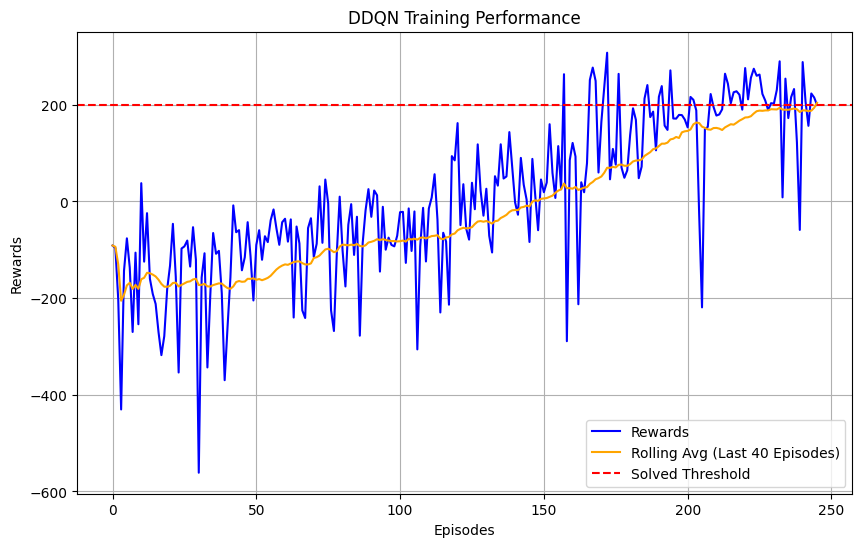

In [10]:
# Plot rewards with rolling average
plt.figure(figsize=(10, 6))
plt.plot(episode_rewards, label='Rewards', color='blue')
plt.plot(rolling_avg_rewards, label='Rolling Avg (Last '+str(ROLLING_WINDOW)+' Episodes)', color='orange')
plt.axhline(y=solved_threshold, color='red', linestyle='--', label='Solved Threshold')
plt.title('DDQN Training Performance')
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.legend()
plt.grid()
plt.show()

#### **Testing 10 episodes with the DDQN trained networks**

In [11]:
# Testing for 10 episodes
start_time = time.time()

for e_test in range(10):  # Run 10 test episodes
    state, _ = env.reset()
    state = np.reshape(state, [1, state_size])
    total_reward = 0
    
    steps = 0
    while True:
        # Use the trained model for testing
        action = agent.action(state)  # Predict action values


        next_state, reward, done, truncated, _ = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])
        total_reward += reward
        state = next_state
        steps = steps + 1
        if done or truncated:
            print(f"Test Episode: {e_test + 1:2}/10, Reward: {total_reward:.2f}, Steps: {steps:3}")
            break

end_time = time.time()
testing_duration = (end_time - start_time) / 60  # Convert to minutes
print(f"Testing completed in {testing_duration:.2f} minutes")

Test Episode:  1/10, Reward: 224.52, Steps: 587
Test Episode:  2/10, Reward: 121.75, Steps: 634
Test Episode:  3/10, Reward: 171.42, Steps: 456
Test Episode:  4/10, Reward: 230.74, Steps: 428
Test Episode:  5/10, Reward: 190.79, Steps: 469
Test Episode:  6/10, Reward: 197.93, Steps: 596
Test Episode:  7/10, Reward: 188.85, Steps: 469
Test Episode:  8/10, Reward: 234.69, Steps: 419
Test Episode:  9/10, Reward: 162.10, Steps: 386
Test Episode: 10/10, Reward: 159.01, Steps: 438
Testing completed in 6.55 minutes


In [12]:
# Test the trained agent with video rendering
# This code is useful if you are using colab otherwise use render_mode='human'
env = gym.make(('LunarLander-v3'), render_mode='rgb_array')  # Enable RGB rendering
frames = []  # Store frames for visualization

# Render a single test episode
state, _ = env.reset()
state = np.reshape(state, [1, state_size])
tot_rewards = 0

while True:
    # Use the trained model for action
    action = agent.action(state)            # Predict action value

    next_state, reward, done, truncated, _ = env.step(action)
    frames.append(env.render())                  # Save frame for rendering later
    next_state = np.reshape(next_state, [1, state_size])
    tot_rewards += reward
    state = next_state

    if done or truncated:
        print(f"Rendered Test Episode Reward: {tot_rewards:.2f}")
        break

env.close()

# Save the rendered episode as a GIF
def save_frames_as_gif(frames, path='./', filename='CARTPOLE_DDQN-Agent.gif'):
    images = [Image.fromarray(frame) for frame in frames]
    gif_path = os.path.join(path, filename)
    images[0].save(gif_path, save_all=True, append_images=images[1:], duration=50, loop=0)
    print(f"Saved GIF to: {gif_path}")

save_frames_as_gif(frames, filename='CARTPOLE_DDQN-Agent.gif')


Rendered Test Episode Reward: 158.79
Saved GIF to: ./CARTPOLE_DDQN-Agent.gif


In [14]:
import session_info
session_info.show(html=False)

-----
PIL                 11.1.0
gymnasium           1.0.0
keras               3.8.0
matplotlib          3.10.0
numpy               2.0.2
session_info        1.0.0
tensorflow          2.18.0
-----
IPython             8.32.0
jupyter_client      8.6.3
jupyter_core        5.7.2
jupyterlab          4.3.5
notebook            7.3.2
-----
Python 3.12.3 (main, Jan 17 2025, 18:03:48) [GCC 13.3.0]
Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.39
-----
Session information updated at 2025-02-11 08:07
